In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import math

In [3]:
from lera.model.transformer import TransformerBlockWithLoadBalancing
from lera.model.moe import MoEWithLoadBalancing


In [4]:
# Define vocabulary and encoding/decoding
vocab = "0123456789ri+=_"
vocab_size = len(vocab)

def encode(s):
    return [vocab.index(c) for c in s]

def decode(l):
    return ''.join([vocab[i] for i in l])

IGNORE_INDEX = vocab_size - 1
print(f"Vocabulary: {vocab}")
print(f"Vocab size: {vocab_size}")
print(f"Expected starting loss: {math.log(vocab_size)}")

Vocabulary: 0123456789ri+=_
Vocab size: 15
Expected starting loss: 2.70805020110221


In [5]:
df = pd.read_csv("../data/train_64k.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X = torch.tensor(df['seq'].apply(ast.literal_eval).tolist()).to(device)
print(f"Dataset size: {X.shape[0]} sequences")
print(f"Sequence length: {X.shape[1]}")
# Create loss mask (only compute loss on the output part)
loss_mask = torch.ones_like(X).to(device)
loss_mask[:, :10] = 0  # Don't compute loss on input
print(f"Loss mask: {loss_mask[0]}")

Using device: cuda
Dataset size: 64000 sequences
Sequence length: 14
Loss mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


In [14]:
class StandardTransformer(nn.Module):
    """Standard autoregressive transformer with causal attention only."""
    def __init__(self, d_model, n_heads, num_layers, vocab_size):
        super().__init__()
        self.encoder = nn.Embedding(vocab_size, d_model)
        
        # Stack of causal transformer blocks (no MoE, no bidirectional)
        self.layers = nn.ModuleList([
            TransformerBlockWithLoadBalancing(
                d_model, n_heads, is_causal=True,
                use_moe=False, num_experts=1  # Not used since use_moe=False
            )
            for _ in range(num_layers)
        ])
        
        self.decoder = nn.Linear(d_model, vocab_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        """Simple forward pass through all layers."""
        for layer in self.layers:
            x = layer(x)
        return x

In [15]:
# Create dataset and dataloader
class AdditionDataset(Dataset):
    def __init__(self, X, loss_mask):
        self.X = X
        self.loss_mask = loss_mask

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.loss_mask[idx]

dataset = AdditionDataset(X, loss_mask)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
print(f"Created dataloader with batch size 8000")
print(f"Number of batches: {len(loader)}")


Created dataloader with batch size 8000
Number of batches: 250


In [16]:
# Model hyperparameters
D_MODEL = 32
N_HEADS = 2
NUM_LAYERS = 4  # Stack of transformer layers instead of recursions

print("Model Configuration (Standard Autoregressive):")
print(f"  d_model: {D_MODEL}")
print(f"  n_heads: {N_HEADS}")
print(f"  num_layers: {NUM_LAYERS}")


Model Configuration (Standard Autoregressive):
  d_model: 32
  n_heads: 2
  num_layers: 4


### Training Loop

This cell will train the standard autoregressive model for 3 epochs using only the task loss (no load balancing).


In [17]:
# Create standard autoregressive model
model = StandardTransformer(
    d_model=D_MODEL,
    n_heads=N_HEADS,
    num_layers=NUM_LAYERS,
    vocab_size=vocab_size,
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel created!")
print(f"Total parameters: {total_params:,}")

# Create optimizer
optimizer = AdamW(model.parameters(), lr=0.001)
print("Optimizer created with lr=0.001")
from tqdm import tqdm
import torch.nn.functional as F

# Training loop (task loss only)
model.train()
epochs = 3

# Track metrics
task_losses = []

print("Starting training...\n")

for epoch in range(epochs):
    print(f"=== Epoch {epoch + 1}/{epochs} ===")
    
    # Wrap your loader with tqdm
    pbar = tqdm(enumerate(loader), total=len(loader), dynamic_ncols=True)
    
    for batch_idx, (batch_x, batch_mask) in pbar:
        # Forward pass
        x_emb = model.encoder(batch_x)
        
        # Forward through model (simple autoregressive)
        y_emb = model(x_emb[:, :-1])
        y_hat = model.decoder(y_emb)
        
        # Task loss (cross entropy)
        loss = F.cross_entropy(
            input=y_hat.permute(0, 2, 1),
            target=batch_x[:, 1:],
            reduction="none"
        )
        masked_loss = loss * batch_mask[:, 1:]
        task_loss = masked_loss.mean() * 14/4
        
        # Backprop
        optimizer.zero_grad()
        task_loss.backward()
        optimizer.step()
        
        # Track losses
        task_losses.append(task_loss.item())
        
        # Update tqdm bar with current loss
        pbar.set_description(f"Batch {batch_idx+1}/{len(loader)}")
        pbar.set_postfix({
            "Loss": f"{task_loss.item():.3f}"
        })

print("Training complete!")



Model created!
Total parameters: 51,791
Optimizer created with lr=0.001
Starting training...

=== Epoch 1/3 ===


Batch 182/250:  73%|███████▎  | 182/250 [00:05<00:02, 33.69it/s, Loss=1.798]


KeyboardInterrupt: 

### Visualize Training Progress


In [ ]:
# Print model parameter count
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 51,791


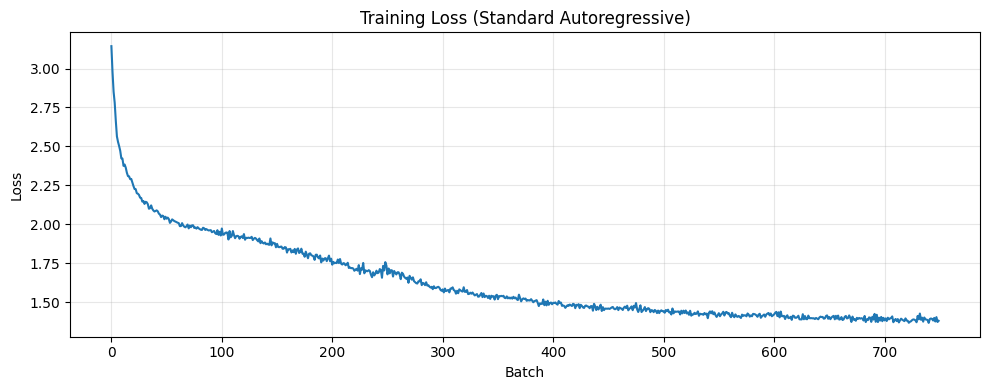


Final training loss: 1.3791


In [ ]:
# Plot training losses
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(task_losses)
ax.set_title('Training Loss (Standard Autoregressive)')
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal training loss: {task_losses[-1]:.4f}")


In [ ]:
val = pd.read_csv("../data/val_4k.csv").iloc[:128]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fix: Use 'val' instead of 'df'
X_test = torch.tensor(val['seq'].apply(ast.literal_eval).tolist()).to(device)
print(f"Dataset size: {X_test.shape[0]} sequences")
print(f"Sequence length: {X_test.shape[1]}")
# Create loss mask (only compute loss on the output part)
loss_mask_test = torch.ones_like(X_test).to(device)
loss_mask_test[:, :10] = 0  # Don't compute loss on input
print(f"Loss mask: {loss_mask_test[0]}")

Using device: cuda
Dataset size: 128 sequences
Sequence length: 14
Loss mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')


In [ ]:
# Evaluate model with batching to avoid OOM
model.eval()
batch_size = 256
num_batches = (X_test.shape[0] + batch_size - 1) // batch_size

all_losses = []

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, X_test.shape[0])
        
        batch_x = X_test[start_idx:end_idx]
        batch_mask = loss_mask_test[start_idx:end_idx]  # Use correct mask
        
        # Forward pass (simple autoregressive)
        x_emb = model.encoder(batch_x)
        y_emb = model(x_emb[:, :-1])
        y_hat = model.decoder(y_emb)
        
        # Task loss (cross entropy)
        loss = F.cross_entropy(
            input=y_hat.permute(0, 2, 1),
            target=batch_x[:, 1:],
            reduction="none"
        )
        masked_loss = loss * batch_mask[:, 1:]
        batch_task_loss = masked_loss.mean() * 14/4
        all_losses.append(batch_task_loss.item())

# Average loss across all batches
task_loss = sum(all_losses) / len(all_losses)
print(f"Validation Loss: {task_loss:.4f}")

Validation Loss: 1.7969


In [ ]:
# Summary: Autoregressive Baseline Results
print("=" * 60)
print("STANDARD AUTOREGRESSIVE BASELINE SUMMARY")
print("=" * 60)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Final Training Loss: {task_losses[-1]:.4f}")
print(f"Validation Loss: {task_loss:.4f}")
print("\nCompare these results with the reasoning architecture in:")
print("  moe_load_balancing.ipynb")
print("=" * 60)

STANDARD AUTOREGRESSIVE BASELINE SUMMARY
Model Parameters: 10,335
Final Training Loss: 1.7559
Validation Loss: 1.7969

Compare these results with the reasoning architecture in:
  moe_load_balancing.ipynb


In [ ]:
## Comparison Guide

To compare this standard autoregressive baseline with the reasoning architecture:

### Key Differences:
1. **Autoregressive Baseline** (this notebook):
   - Simple stack of causal transformer layers
   - No recursion or bidirectional attention
   - No MoE routing
   - Only task loss (cross-entropy)

2. **Reasoning Model** (moe_load_balancing.ipynb):
   - Bidirectional recursion on input context
   - MoE with load balancing
   - Combined task + load balance loss
   - More complex architecture

### How to Compare:
1. Note the validation loss from this notebook
2. Open `moe_load_balancing.ipynb` and check its validation loss
3. Compare parameter counts
4. Compare training curves

The reasoning architecture should demonstrate whether the added complexity (recursion, bidirectional attention, MoE) provides benefits over a simple autoregressive baseline.

SyntaxError: invalid syntax (2297163361.py, line 3)